<a href="https://colab.research.google.com/github/MDankloff/Cluster-Bias-Disco/blob/main/BAF_RFmodels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [ ]:
!pip install google-colab
!pip install dask[dataframe]
!pip install pyarrow
!pip install aequitas
!pip install optuna

In [9]:
from google.colab import drive
drive.mount('/content/drive')

!git clone https://github.com/feedzai/bank-account-fraud.git

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
fatal: destination path 'bank-account-fraud' already exists and is not an empty directory.


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgbm
import yaml              # Read hyperparameter space configuration
import glob
import os
import logging
import sys
import joblib

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, f1_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder # Categorical encoding for LGBM models
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn import metrics
from aequitas.group import Group    # Fairness metrics
from lightgbm import LGBMClassifier

# Load Data

In [12]:
base_path = '/content/drive/MyDrive/Mirthe_Supervision /Paper#3/BAF/parquet data'

extension = "parquet" #for smaller "parquet" depending on the downloaded file
data_paths = glob.glob(f"{base_path}/*.{extension}")

def read_dataset(path, ext = extension):
    if ext == "csv":
      return pd.read_csv(path)
    elif ext == "parquet":
      return pd.read_parquet(path)
    else:
      raise ValueError(f"Unsupported file extension: {ext}")

# Extract variant name from the file path (without the extension)
def get_variant(path):
    return os.path.basename(path).split(".")[0]

# Dictionary comprehension to read all CSV files into a dictionary of DataFrames
dataframes = {
    get_variant(path): read_dataset(path) for path in data_paths
}
print(f"Loaded datasets: {list(dataframes.keys())}")

datasets_paths = {
    "Base": base_path + "/Base.parquet", # sampled to best represent original dataset
    "Variant I": base_path + "/Variant I.parquet", # higher group size disparity than base - reducing the size of the minority group from approx 20 - 10% of the dataset
    "Variant II": base_path + "/Variant II.parquet", # higher prevalence disparity than base - one group has 5 x the fraud detection rate of the other while group sizes are equal
    "Variant III": base_path + "/Variant III.parquet", # better separability for one of the groups -
    "Variant IV": base_path + "/Variant IV.parquet", # higher prevalence disparity in train
    "Variant V": base_path + "/Variant V.parquet", # better separability in train for one of the groups
}

Loaded datasets: ['Base', 'Variant I', 'Variant II', 'Variant III', 'Variant IV', 'Variant V']


In [13]:
datasets = {key: read_dataset(path) for key, path in datasets_paths.items()}

# Train RF Models

In [19]:
# Define the label field and categorical columns.
label = "fraud_bool"

categorical_features = [
    "payment_type",
    "employment_status",
    "housing_status",
    "source",
    "device_os",
]

In [20]:
# Create the train and test sets. Shuffle data with `sample` method.
# The split was done by month. The first 6 months as the train, the last 2 months as test.
train_dfs = {key: df[df["month"]<6].sample(frac=1, replace=False) for key, df in datasets.items()}
test_dfs = {key: df[df["month"]>=6].sample(frac=1, replace=False) for key, df in datasets.items()}

In [21]:
# Encode the categorical variables in the datasets to integers.
# This is expected by LGBM (or columns with the `categorical` data type).

for name in datasets.keys():  # For each dataset in the suite
    train = train_dfs[name]
    test = test_dfs[name]

    for feat in categorical_features:
        encoder = LabelEncoder()
        encoder.fit(train[feat])  # Fit an encoder to the train set.
        train[feat] = encoder.transform(train[feat])  # Transform train set.
        test[feat] = encoder.transform(test[feat])    # Transform test set.

In [24]:
# Define path to save the models
rfmodels_path = "saved_rfmodels"
if not os.path.exists(rfmodels_path):
    os.makedirs(rfmodels_path)

# initialize dictionary to store the results
runs = {}

# iterate through each dataset to train an RF model
for dataset_name in datasets.keys():
  # create and fit the model
  model = RandomForestClassifier(random_state = 42, n_jobs=-1)
  X_train = train_dfs[dataset_name].drop(columns=["fraud_bool"])
  y_train = train_dfs[dataset_name]["fraud_bool"]
  X_test = test_dfs[dataset_name].drop(columns=["fraud_bool"])
  y_test = test_dfs[dataset_name]["fraud_bool"]

# Fit model to training data
  model.fit(X_train, y_train) # , categorical_feature=categorical_features)

# save the model to training data
  model_filename= os.path.join(rfmodels_path, f"{dataset_name}_rf_model.pkl")
  joblib.dump(model, model_filename)

# predict
  predictions = model.predict_proba(X_test)[:, 1]
  fprs, tprs, thresholds = roc_curve(y_test, predictions)
  threshold = np.min(thresholds[fprs == max(fprs[fprs < 0.05])])
  recall = np.max(tprs[fprs == max(fprs[fprs < 0.05])])

# Binarize predictions for Aequitas
  preds_binary = (predictions > threshold).astype(int)

# Create a dataframe for evaluation
  aequitas_df = pd.DataFrame(
      {
          "age": (X_test["customer_age"] >= 50).map({True: "Older", False: "Younger"}),
          "preds": preds_binary,
          "y": y_test.values
      }
  )

  # Aequitas evaluation
  g = Group()
  aequitas_results = g.get_crosstabs(aequitas_df, attr_cols=["age"], score_col="preds", label_col="y")[0]

  # Compute F1 score
  f1 = f1_score(y_test, preds_binary)

  # Store results in a dictionary
  results = {}
  results["recall"] = recall
  results["recall Older"] = aequitas_results[aequitas_results["attribute_value"] == "Older"][["tpr"]].values[0][0]
  results["recall Younger"] = aequitas_results[aequitas_results["attribute_value"] == "Younger"][["tpr"]].values[0][0]
  results["fpr Older"] = aequitas_results[aequitas_results["attribute_value"] == "Older"][["fpr"]].values[0][0]
  results["fpr Younger"] = aequitas_results[aequitas_results["attribute_value"] == "Younger"][["fpr"]].values[0][0]
  results['f1'] = f1

  # Save the metrics in the runs dictionary
  prev_runs = runs.get(dataset_name, [])
  prev_runs.append(results)
  runs[dataset_name] = prev_runs


In [25]:
# Create a dataframe with the results for each model in each dataset.
rs_results = pd.DataFrame(runs)
#rs_results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Base         1 non-null      object
 1   Variant I    1 non-null      object
 2   Variant II   1 non-null      object
 3   Variant III  1 non-null      object
 4   Variant IV   1 non-null      object
 5   Variant V    1 non-null      object
dtypes: object(6)
memory usage: 176.0+ bytes


In [26]:
# Helper method to obtain the metric values for a given model.
def get_results(results, variant, metric):
    col = results[variant]
    values = []
    for idx, val in col.items():#iteritems():
        values.append(val[metric])
    return values

In [27]:
# Obtain the relevant metrics to plots from the dataframe.
variants = list(datasets_paths.keys())

plot_results = {"Variant": [], "Recall": [], "FPR Ratio": []}

for variant in variants:
    plot_results["Recall"] += get_results(rs_results, variant, "recall")
    # Obtain the FPR if both groups.
    for fpr_younger, fpr_older in zip(get_results(rs_results, variant, "fpr Younger"), get_results(rs_results, variant, "fpr Older")):
        # Calculate FPR ratio as higher fpr / lower fpr
        if fpr_younger > fpr_older:
            plot_results["FPR Ratio"] += [fpr_older/fpr_younger]
        else:
            plot_results["FPR Ratio"] += [fpr_younger/fpr_older]
    plot_results["Variant"] += [variant] * len(get_results(rs_results, variant, "recall"))

# Create a dataframe for easier plots.
plot_results = pd.DataFrame(plot_results)

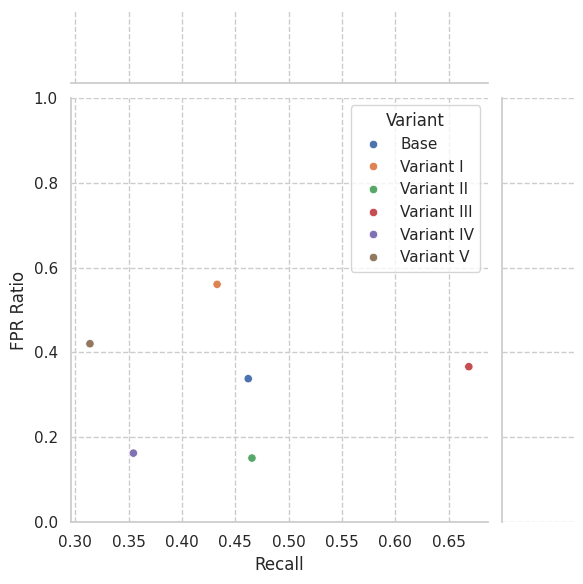

In [28]:
# Create a plot with the full results of the random search algorithm.
sns.set()
sns.set_style("whitegrid", {"grid.linestyle": "--"})

sns.jointplot(data=plot_results, x="Recall", y="FPR Ratio", hue="Variant")
plt.ylim((0,1));

In [29]:
# Extract F1 scores for each variant
def get_f1_scores(results, variant):
    return [trial["f1"] for trial in results[variant]]

# Prepare a summary dataframe
f1_summary = {
    "Variant": [],
    "Trial": [],
    "F1 Score": [],
}

for variant in datasets.keys():
    f1_scores = get_f1_scores(runs, variant)
    for trial_idx, f1 in enumerate(f1_scores):
        f1_summary["Variant"].append(variant)
        f1_summary["Trial"].append(trial_idx)
        f1_summary["F1 Score"].append(f1)

f1_summary_df = pd.DataFrame(f1_summary)

In [30]:
# Get the top models based on F1 score
top_f1_models = f1_summary_df.sort_values("F1 Score", ascending=False).groupby("Variant").head(1)
print(top_f1_models)

       Variant  Trial  F1 Score
3  Variant III      0  0.260601
2   Variant II      0  0.201824
0         Base      0  0.199951
1    Variant I      0  0.188857
4   Variant IV      0  0.133375
5    Variant V      0  0.120753


In [32]:
import joblib

modelbase_path = '/content/saved_rfmodels/Variant III_rf_model.pkl'
modelb = joblib.load(modelbase_path)

feature_importances = modelb.feature_importances_
print("Feature Importances:", feature_importances)

Feature Importances: [0.01766892 0.04895816 0.00579901 0.03859424 0.03561972 0.04451407
 0.04219304 0.0095442  0.04294734 0.04189732 0.04150965 0.04358138
 0.02818694 0.02763593 0.0093551  0.04522024 0.00644218 0.01527744
 0.00823555 0.00520568 0.01938572 0.00454443 0.01852382 0.00332037
 0.0011004  0.04334526 0.01152941 0.0058634  0.00685135 0.
 0.01551397 0.15455831 0.15707747]


Accuracy: 0.9917
Precision: 0.9540
Recall: 0.2579
F1-Score: 0.4061
ROC AUC: 0.9075
Confusion Matrix:
[[238987     33]
 [  1968    684]]


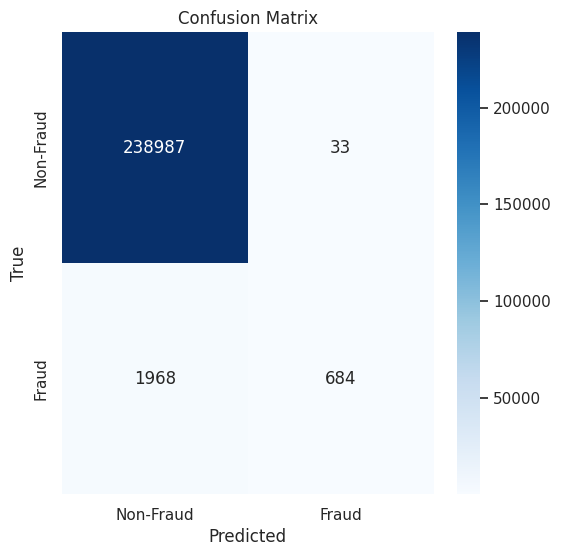

In [34]:
# Load the model
modelb = joblib.load(modelbase_path)

# Assuming train_dfs and test_dfs are already loaded as described in your example

# Get the dataset name (make sure it's available in your dataset context)
dataset_name = "Variant III"  # Replace with the actual dataset name used during training

# Prepare test data
X_test = test_dfs[dataset_name].drop(columns=["fraud_bool"])
y_test = test_dfs[dataset_name]["fraud_bool"]

# Predict with the loaded model
y_pred = modelb.predict(X_test)
y_prob = modelb.predict_proba(X_test)[:, 1]  # Get probabilities for ROC AUC (for class 1)

# Calculate and print error metrics
accuracy = accuracy_score(y_test, y_pred)
# Import precision_recall_fscore_support directly
from sklearn.metrics import precision_recall_fscore_support
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
conf_matrix = confusion_matrix(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

# Print the results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

# Print Confusion Matrix
print("Confusion Matrix:")
print(conf_matrix)

# Plot Confusion Matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Fraud", "Fraud"], yticklabels=["Non-Fraud", "Fraud"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Exploring class imbalance

In [37]:
Variant3 = datasets['Variant III']
print(Variant3.columns)

Index(['fraud_bool', 'income', 'name_email_similarity',
       'prev_address_months_count', 'current_address_months_count',
       'customer_age', 'days_since_request', 'intended_balcon_amount',
       'payment_type', 'zip_count_4w', 'velocity_6h', 'velocity_24h',
       'velocity_4w', 'bank_branch_count_8w',
       'date_of_birth_distinct_emails_4w', 'employment_status',
       'credit_risk_score', 'email_is_free', 'housing_status',
       'phone_home_valid', 'phone_mobile_valid', 'bank_months_count',
       'has_other_cards', 'proposed_credit_limit', 'foreign_request', 'source',
       'session_length_in_minutes', 'device_os', 'keep_alive_session',
       'device_distinct_emails_8w', 'device_fraud_count', 'month', 'x1', 'x2'],
      dtype='object')


In [39]:
Variant3['customer_age'].value_counts()

,count
customer_age,
50,383161
30,188523
20,146955
40,145665
60,99828
70,18690
10,12996
80,3910
90,272
